# BBC News Mini Project

## Step 1: EDA - Inspect, Visualize and Clean the Data

Data fields

    ArticleId - Unique # given to the record
    Article - Header text and article
    Category - category of the article (entertainment, tech, sport, business,   politics)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
import datetime
from datetime import datetime, timedelta, date
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
!pip install scikit-surprise==1.1.4
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
%matplotlib inline
%autosave 60
sns.set_style('dark')
sns.set(font_scale=1.2)
plt.rc('axes', titlesize=9)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)
random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Autosaving every 60 seconds


In [42]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/BBC News Train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Display the first few rows of the DataFrame to get an initial look at the data
print("First 5 rows of the DataFrame:")
print(df.head())
print("\n")

# Get a concise summary of the DataFrame, including data types and non-null values
print("Summary of DataFrame info:")
print(df.info())
print("\n")

# Count the occurrences of each data type in the DataFrame
print("Data types count:")
print(df.dtypes.value_counts())
print("\n")

# List all column names in the DataFrame
print("Column names:")
print(df.columns)
print("\n")

# Show the shape of the DataFrame (number of rows and columns)
print("Shape of the DataFrame (rows, columns):")
print(df.shape)
print("\n")

# Check for any missing values in each column
print("Missing values in each column:")
print(df.isnull().sum())
print("\n")

# Check for duplicate rows in the DataFrame
print("Number of duplicate rows:")
print(df.duplicated().sum())


First 5 rows of the DataFrame:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


Summary of DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


Data types count:
object    2
int64     1
Name: count, dtype: int64


Column names:
Index(['ArticleId', 'Text', 'Category'], dtype='objec

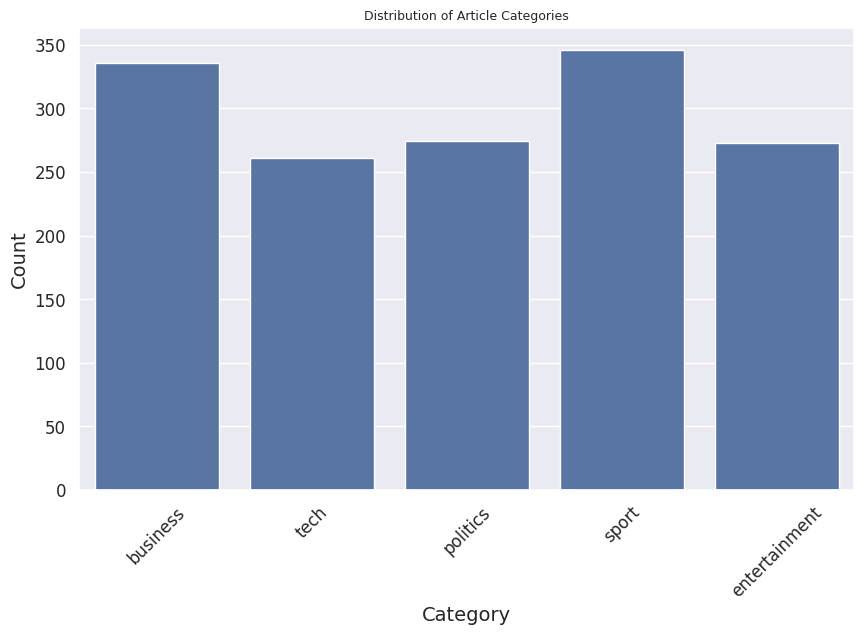

In [44]:
# Set the size of the figure for better readability
plt.figure(figsize=(10, 6))

# Create a count plot to visualize the distribution of article categories
sns.countplot(x='Category', data=df)

# Add a title and labels for clarity
plt.title('Distribution of Article Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()


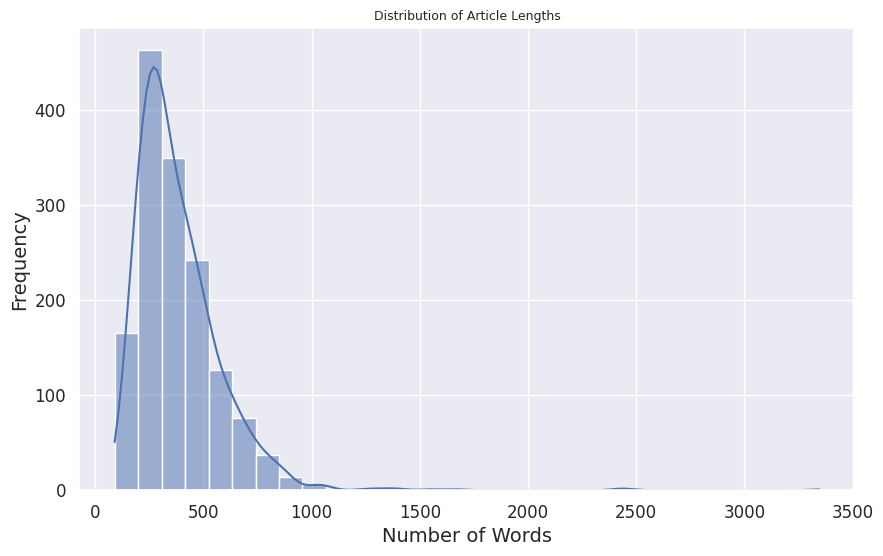

In [45]:
# Add a new column to the DataFrame that contains the length of each article (in number of words)
df['Article_Length'] = df['Text'].apply(lambda x: len(x.split()))

# Set the size of the figure for better visualization
plt.figure(figsize=(10, 6))

# Plot a histogram to visualize the distribution of article lengths
# The 'kde=True' parameter adds a Kernel Density Estimate line to the histogram
sns.histplot(df['Article_Length'], bins=30, kde=True)

# Add a title and labels for clarity
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Display the plot
plt.show()


In [46]:
# Function to preprocess the text data
def preprocess_text(text):
    # Define the set of English stop words to remove common, less informative words
    stop_words = set(stopwords.words('english'))

    # Initialize and Tokenize the text into individual words
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)

    # Lemmatize, lowercase, and remove stop words and non-alphabetic tokens
    tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in tokens
        if word.isalpha() and word.lower() not in stop_words
    ]

    # Join the processed tokens back into a single string
    return ' '.join(tokens)


In [47]:
df['Processed_Text'] = df['Text'].apply(preprocess_text)
df.head()

,ArticleId,Text,Category,Article_Length,Processed_Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,worldcom launch defence lawyer defending forme...
1,154,german business confidence slides german busin...,business,325,german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,bbc poll indicates economic gloom citizen majo...
3,1976,lifestyle governs mobile choice faster bett...,tech,634,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,355,enron boss payout eighteen former enron direct...


In [48]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Text'])

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical method that measures the importance of a word in a document relative to a collection of documents. The value increases with the frequency of the word in the document but is balanced by its occurrence across the corpus, ensuring that common words are given less weight. The formula combines Term Frequency (TF) and Inverse Document Frequency (IDF) to calculate the TF-IDF value, which is particularly useful in text classification as it highlights significant terms while downplaying less informative, common words.



TF-IDF is chosen here because it is straightforward to implement and effective for text classification tasks. It highlights important words while reducing the weight of common but less informative words. This makes the feature vectors more informative and suitable for machine learning models.





#### 1: When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

Avoid using texts from the test dataset in training an unsupervised matrix factorization model. Including test data can cause data leakage, leading to overfitting and misleading performance metrics. The test set is meant to evaluate how well the model generalizes to new, unseen data.

In [49]:
# Convert TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head(10)

abandoned  abbas  abc  ability  able  abroad  absa  absence  absolute  absolutely  abuse  abused   ac  academy  accept  acceptable  accepted  accepting  access  accessible  accident  acclaimed  accolade  according  account  accounting  accurate  accused  accusing  achieve  achieved  achievement  achieving  acknowledged  acquisition  across  act  acted  acting  action  active  actively  activist  activity  actor  actress  actual  actually   ad  adam  adapt  adaptation  adapted  add  added  adding  addition  additional  address  addressing  adequately  administration  administrator  admission  admit  admits  admitted  adopt  adopted  adoption  adrian  adriano  adult  advance  advanced  advantage  adventure  advert  advertising  advice  advised  adviser  advisor  advocate  aer  affair  affect  affected  affecting  afford  affordable  afghanistan  afraid  africa  african  afternoon  afterwards  agassi  age  aged  agency  agenda  agent  aggressive  ago  agree  agreed  agreeing  \
0       0.00   0.00 0.00     0.00  0.00    0.00  0.00     0.00      0.00        0.00   0.00    0.00 0.00     0.00    0.00        0.00      0.00       0.00    0.00        0.00      0.00       0.00      0.00       0.00     0.00        0.38      0.00     0.00      0.00     0.00      0.00         0.00       0.00          0.00         0.00    0.00 0.00   0.00    0.00    0.00    0.00      0.00      0.00      0.00   0.00     0.00    0.00      0.00 0.00  0.00   0.00        0.00     0.00 0.00   0.00    0.00      0.00        0.00     0.00        0.00        0.00            0.00           0.00       0.00   0.00    0.00      0.00   0.00     0.00      0.00    0.00     0.00   0.00     0.00      0.00       0.00       0.00    0.00         0.00    0.00     0.00     0.00     0.00      0.00 0.00    0.00    0.00      0.00       0.00    0.00        0.00         0.00    0.00    0.00     0.00       0.00        0.00    0.00 0.00  0.00    0.00    0.00   0.00        0.00 0.00   0.00    0.04      0.00   
1       0.00   0.00 0.00     0.00  0.00    0.00  0.00     0.00      0.00        0.00   0.00    0.00 0.00     0.00    0.00        0.00      0.00       0.00    0.00        0.00      0.00       0.00      0.00       0.00     0.00        0.00      0.00     0.00      0.00     0.00      0.00         0.00       0.00          0.00         0.00    0.00 0.00   0.00    0.00    0.00    0.00      0.00      0.00      0.07   0.00     0.00    0.00      0.00 0.00  0.00   0.00        0.00     0.00 0.00   0.00    0.00      0.00        0.00     0.00        0.00        0.00            0.00           0.00       0.00   0.00    0.00      0.00   0.00     0.00      0.00    0.00     0.00   0.00     0.00      0.00       0.00       0.00    0.00         0.00    0.00     0.00     0.00     0.00      0.00 0.00    0.00    0.00      0.00       0.00    0.00        0.00         0.00    0.00    0.00     0.00       0.00        0.00    0.00 0.00  0.00    0.00    0.00   0.00        0.00 0.00   0.00    0.00      0.00   
2       0.00   0.00 0.00     0.00  0.00    0.00  0.00     0.00      0.00        0.00   0.00    0.00 0.00     0.00    0.00        0.00      0.00       0.00    0.00        0.00      0.00       0.00      0.00       0.00     0.00        0.00      0.00     0.00      0.00     0.00      0.00         0.00       0.00          0.00         0.00    0.04 0.00   0.00    0.00    0.00    0.00      0.00      0.00      0.00   0.00     0.00    0.00      0.00 0.00  0.00   0.00        0.00     0.00 0.00   0.00    0.00      0.00        0.00     0.00        0.00        0.00            0.00           0.00       0.00   0.00    0.00      0.00   0.00     0.00      0.00    0.00     0.00   0.00     0.00      0.00       0.00       0.00    0.00         0.00    0.00     0.00     0.00     0.00      0.00 0.00    0.00    0.00      0.00       0.00    0.00        0.00         0.00    0.00    0.00     0.00       0.00        0.00    0.00 0.00  0.00    0.00    0.00   0.00        0.00 0.04   0.00    0.00      0.00   
3       0.00   0.00 0.00     0.

#### 2: Build a model using Matrix Factorization

In [50]:
# Generate user-item-rating triplets
ratings_list = [
    [doc_id, word_id, tfidf_score]
    for doc_id, doc in enumerate(tfidf_df.values)
    for word_id, tfidf_score in enumerate(doc)
    if tfidf_score > 0
]

ratings_df = pd.DataFrame(ratings_list, columns=['doc_id', 'word_id', 'rating'])
ratings_df.head()


,doc_id,word_id,rating
0,0,25,0.38
1,0,106,0.04
2,0,134,0.06
3,0,157,0.02
4,0,199,0.05


In [51]:
# Define the rating scale based on the maximum TF-IDF score
reader = Reader(rating_scale=(0, tfidf_matrix.max()))

# Load the DataFrame into a Surprise Dataset
data = Dataset.load_from_df(ratings_df[['doc_id', 'word_id', 'rating']], reader)

# Split the data into training and test sets
trainset, testset = surprise_train_test_split(data, test_size=0.2)

# Apply matrix factorization using SVD
svd = SVD(n_factors=100, random_state=42)
svd.fit(trainset)
# Extract the latent features
doc_latent_features = np.array([svd.pu[i] for i in range(tfidf_df.shape[0])])

In [52]:
doc_latent_features

array([[ 0.03313634, -0.00794498,  0.06198539, ...,  0.02534795,
        -0.01067564, -0.03462212],
       [-0.12452273, -0.0372913 , -0.03350056, ...,  0.0059305 ,
         0.00029697, -0.1080592 ],
       [ 0.02355798,  0.03346642,  0.09356827, ...,  0.0330559 ,
         0.05923066,  0.05643356],
       ...,
       [-0.12864701, -0.09834842, -0.14702438, ..., -0.02399716,
        -0.13042161, -0.10199667],
       [-0.05240152, -0.00687686,  0.06003257, ...,  0.12001771,
        -0.08461319, -0.031959  ],
       [ 0.07132756,  0.03497252,  0.30007721, ..., -0.02710041,
        -0.22610443,  0.04932574]])

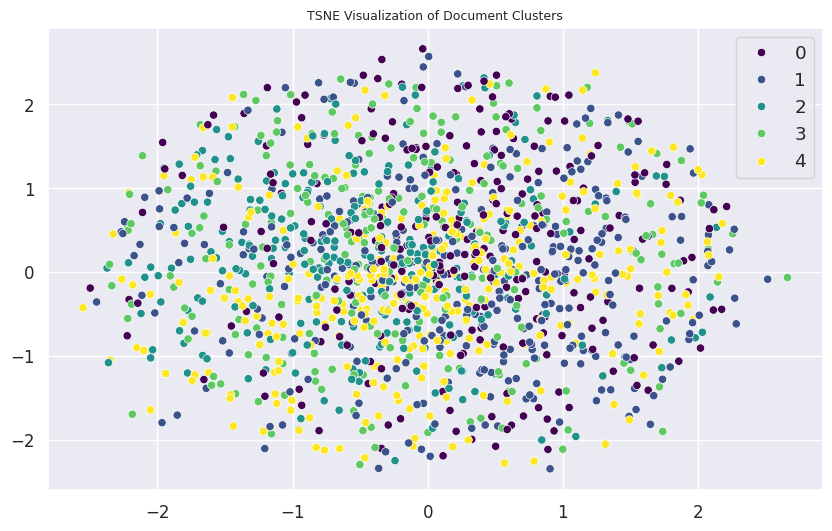

In [53]:
# Clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(doc_latent_features)
# Visualize the clusters using TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(doc_latent_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=clusters, palette='viridis')
plt.title('TSNE Visualization of Document Clusters')
plt.show()

In [54]:
# Add cluster labels to the dataframe
df['Cluster'] = clusters

# Encode original categories
label_encoder = LabelEncoder()
df['Category_Encoded'] = label_encoder.fit_transform(df['Category'])

In [55]:
df.head()

,ArticleId,Text,Category,Article_Length,Processed_Text,Cluster,Category_Encoded
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,worldcom launch defence lawyer defending forme...,1,0
1,154,german business confidence slides german busin...,business,325,german business confidence slide german busine...,0,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,bbc poll indicates economic gloom citizen majo...,0,0
3,1976,lifestyle governs mobile choice faster bett...,tech,634,lifestyle governs mobile choice faster better ...,3,4
4,917,enron bosses in $168m payout eighteen former e...,business,355,enron boss payout eighteen former enron direct...,3,0


#### 3: Performance Evaluation
Evaluate the model using accuracy, confusion matrices, and a detailed classification report (including precision, recall, and F1-score).

#### 4: Hyperparameter Tuning
Experiment with hyperparameters like latent factors (n_factors), KMeans clusters, and logistic regression iterations. Record and compare results to identify the best configuration.

#### 5: Performance Enhancement
Improve the model by trying different feature extraction methods (e.g., GloVe, Word2Vec), training on various data subsets, or using ensemble techniques.

In [56]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    doc_latent_features, df['Category_Encoded'],
    test_size=0.2, random_state=42
)

# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Evaluate the classifier
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

In [57]:
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('\nTraining Confusion Matrix:')
print(train_conf_matrix)
print('\nTest Confusion Matrix:')
print(test_conf_matrix)
print('\nClassification Report:')
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.3674
Test Accuracy: 0.2248

Training Confusion Matrix:
[[123  25  17  74  22]
 [ 57  49  27  75  19]
 [ 41  16  75  71  15]
 [ 62  22  26 155  18]
 [ 57  26  25  59  36]]

Test Confusion Matrix:
[[24  9  7 25 10]
 [12  6 11 15  2]
 [13  8  9 24  2]
 [14  4 10 19 16]
 [17  4  9 19  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.32      0.31        75
           1       0.19      0.13      0.16        46
           2       0.20      0.16      0.18        56
           3       0.19      0.30      0.23        63
           4       0.23      0.16      0.19        58

    accuracy                           0.22       298
   macro avg       0.22      0.21      0.21       298
weighted avg       0.23      0.22      0.22       298



## Step 3: Compare with supervised learning

In [58]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/BBC News Train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# Text preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['Processed_Text'] = df['Text'].apply(preprocess_text)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Text'])

# Encode categories
label_encoder = LabelEncoder()
df['Category_Encoded'] = label_encoder.fit_transform(df['Category'])

In [60]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix, df['Category_Encoded'],
    test_size=0.2, random_state=42
)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Train Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predict
y_train_pred_log_reg = log_reg.predict(X_train)
y_test_pred_log_reg = log_reg.predict(X_test)
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

# Evaluate Logistic Regression
train_accuracy_log_reg = accuracy_score(y_train, y_train_pred_log_reg)
test_accuracy_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
train_conf_matrix_log_reg = confusion_matrix(y_train, y_train_pred_log_reg)
test_conf_matrix_log_reg = confusion_matrix(y_test, y_test_pred_log_reg)

# Evaluate Random Forest
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
train_conf_matrix_rf = confusion_matrix(y_train, y_train_pred_rf)
test_conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)


In [61]:
print(f'Logistic Regression - Training Accuracy: {train_accuracy_log_reg:.4f}')
print(f'Logistic Regression - Test Accuracy: {test_accuracy_log_reg:.4f}')
print('\nLogistic Regression - Training Confusion Matrix:')
print(train_conf_matrix_log_reg)
print('\nLogistic Regression - Test Confusion Matrix:')
print(test_conf_matrix_log_reg)
print('\nLogistic Regression - Classification Report:')
print(classification_report(y_test, y_test_pred_log_reg))


Logistic Regression - Training Accuracy: 0.9966
Logistic Regression - Test Accuracy: 0.9765

Logistic Regression - Training Confusion Matrix:
[[260   0   0   0   1]
 [  0 227   0   0   0]
 [  0   0 217   0   1]
 [  1   0   0 282   0]
 [  0   1   0   0 202]]

Logistic Regression - Test Confusion Matrix:
[[74  0  1  0  0]
 [ 0 46  0  0  0]
 [ 2  0 53  1  0]
 [ 0  0  0 63  0]
 [ 0  1  1  1 55]]

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        75
           1       0.98      1.00      0.99        46
           2       0.96      0.95      0.95        56
           3       0.97      1.00      0.98        63
           4       1.00      0.95      0.97        58

    accuracy                           0.98       298
   macro avg       0.98      0.98      0.98       298
weighted avg       0.98      0.98      0.98       298



In [62]:
print(f'Random Forest - Training Accuracy: {train_accuracy_rf:.4f}')
print(f'Random Forest - Test Accuracy: {test_accuracy_rf:.4f}')
print('\nRandom Forest - Training Confusion Matrix:')
print(train_conf_matrix_rf)
print('\nRandom Forest - Test Confusion Matrix:')
print(test_conf_matrix_rf)
print('\nRandom Forest - Classification Report:')
print(classification_report(y_test, y_test_pred_rf))

Random Forest - Training Accuracy: 1.0000
Random Forest - Test Accuracy: 0.9698

Random Forest - Training Confusion Matrix:
[[261   0   0   0   0]
 [  0 227   0   0   0]
 [  0   0 218   0   0]
 [  0   0   0 283   0]
 [  0   0   0   0 203]]

Random Forest - Test Confusion Matrix:
[[73  0  2  0  0]
 [ 0 46  0  0  0]
 [ 1  0 55  0  0]
 [ 0  0  0 63  0]
 [ 2  2  1  1 52]]

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        75
           1       0.96      1.00      0.98        46
           2       0.95      0.98      0.96        56
           3       0.98      1.00      0.99        63
           4       1.00      0.90      0.95        58

    accuracy                           0.97       298
   macro avg       0.97      0.97      0.97       298
weighted avg       0.97      0.97      0.97       298



### Step 2: Discuss Comparison with the Unsupervised Approach

When comparing supervised learning methods with unsupervised approaches, key differences in accuracy, data efficiency, and overfitting are evident. Supervised learning techniques, such as Logistic Regression and Random Forest, typically demonstrate superior accuracy on both training and test datasets. These methods are designed to minimize classification errors directly, making them highly effective for tasks where labeled data is available. In contrast, unsupervised approaches, like matrix factorization, focus on uncovering underlying patterns and structures within the data without direct supervision. Consequently, they may not achieve the same level of classification accuracy.

Data efficiency is another area where supervised learning methods often excel. Supervised models require fewer labeled examples to achieve high performance compared to unsupervised models, which generally need larger datasets to identify meaningful patterns and clusters. This difference can be assessed by training supervised models on varying subsets of labeled data (e.g., 10%, 20%, 50%) and evaluating the impact on performance.

Regarding overfitting, supervised models, particularly complex ones like Random Forests with many estimators, can be prone to overfitting. This is usually indicated by a significant disparity between training and test accuracy. On the other hand, unsupervised models are less likely to overfit due to their indirect approach to classification, but they may not reach the same accuracy levels as supervised models.

The analysis reveals distinct advantages of supervised learning methods over unsupervised approaches. **Accuracy** is notably higher with Logistic Regression and Random Forest compared to unsupervised methods. Both Logistic Regression and Random Forest demonstrate strong generalization capabilities when trained on at least 50% of the data, underscoring their effectiveness in achieving high classification performance.

In terms of **data efficiency**, supervised models excel by maintaining reasonable accuracy even with smaller subsets of the training data. This efficiency is evident as these models can perform well without requiring extensive amounts of labeled data. However, the Random Forest model tends to show signs of overfitting, particularly when trained on smaller datasets, due to its complexity.

Regarding **overfitting**, Logistic Regression exhibits a smaller gap between training and test accuracy, suggesting it is less prone to overfitting than Random Forest. In contrast, unsupervised methods are generally less susceptible to overfitting but do not achieve the same level of accuracy as supervised techniques.

Overall, supervised learning methods prove to be more effective for this task as they can directly leverage labeled data to optimize classification performance. While unsupervised methods like matrix factorization can offer valuable insights, they typically require larger datasets and additional post-processing to match the accuracy levels of supervised approaches.